In [1]:
from IPython.display import display
from IPython.display import HTML
import IPython.core.display as di # Example: di.display_html('<h3>%s:</h3>' % str, raw=True)

# This line will hide code by default when the notebook is exported as HTML
di.display_html('<script>jQuery(function() {if (jQuery("body.notebook_app").length == 0) { jQuery(".input_area").toggle(); jQuery(".prompt").toggle();}});</script>', raw=True)

# This line will add a button to toggle visibility of code blocks, for use with the HTML export version
di.display_html('''<button onclick="jQuery('.input_area').toggle(); jQuery('.prompt').toggle();">Toggle code</button>''', raw=True)

Toggle code

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import seaborn as sns

import pickle

from dtw import *

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [4]:
#Form template of layers
# peat | clay | sand

#Number of kinds of materials
N = 3

In [5]:
#Layer names
layer_names = ['peat', 'clay', 'sand']

In [6]:
#Templates with 1 layer
templates_1 = []

#Peat
t = [1, 0, 0]
templates_1.append(t)

#Clay
t = [0, 1, 0]
templates_1.append(t)

#Clayey sand
#t = [0, 0, 1, 0]
#templates_1.append(t)

#Sand
t = [0, 0, 1]
templates_1.append(t)

In [7]:
#Templates with 1 layer
templates_1 = []

for i in range(N):
    t = [0, 0, 0]
    t[i] = 1
    templates_1.append([t])

In [8]:
#templates_1

In [9]:
#Templates with 2 layers
templates_2 = []

for i in range(N):
    t1 = [0, 0, 0]
    t1[i] = 1
    for j in range(N):
        if j!=i:
            t2 = [0, 0, 0]
            t2[j] = 1
            templates_2.append([t1, t2])

In [10]:
#templates_2

In [11]:
#Templates with 3 layers
templates_3 = []

for i in range(N):
    t1 = [0, 0, 0]
    t1[i] = 1
    for j in range(N):
        if j!=i:
            t2 = [0, 0, 0]
            t2[j] = 1
            for k in range(N):
                if k!=j:
                    t3 = [0, 0, 0]
                    t3[k] = 1   
                    templates_3.append([t1, t2, t3])

In [12]:
#templates_3

In [13]:
templates = templates_1 + templates_2 + templates_3

In [14]:
#Add additional layers containing peat
tp = [1, 0, 0] #Peat
tc = [0, 1, 0] #Clay
ts = [0, 0, 1] #Sand

t = [tc, ts] #Layers other than peat

#Length 4 layers
for i in range(2):
    for j in range(2):
        templates.append([tp, t[i], tp, t[j]])
        
for i in range(2):
    for j in range(2):
        templates.append([t[i], tp, t[j], tp]) 
        
#Length 5 layers
for i in range(2):
    for j in range(2):
        templates.append([tp, t[i], tp, t[j], tp])

In [15]:
#Weight of each template. Set equal to length of template
weight_templates = [len(t) for t in templates]

In [16]:
layer_templates = []
for t in templates:
    t1 = []
    for item in t:
        if item==[1,0,0]:
            t1.append('peat')
        if item==[0,1,0]:
            t1.append('clay')  
        if item==[0,0,1]:
            t1.append('sand')
    layer_templates.append(' - '.join(t1))

In [17]:
layer_templates

['peat',
 'clay',
 'sand',
 'peat - clay',
 'peat - sand',
 'clay - peat',
 'clay - sand',
 'sand - peat',
 'sand - clay',
 'peat - clay - peat',
 'peat - clay - sand',
 'peat - sand - peat',
 'peat - sand - clay',
 'clay - peat - clay',
 'clay - peat - sand',
 'clay - sand - peat',
 'clay - sand - clay',
 'sand - peat - clay',
 'sand - peat - sand',
 'sand - clay - peat',
 'sand - clay - sand',
 'peat - clay - peat - clay',
 'peat - clay - peat - sand',
 'peat - sand - peat - clay',
 'peat - sand - peat - sand',
 'clay - peat - clay - peat',
 'clay - peat - sand - peat',
 'sand - peat - clay - peat',
 'sand - peat - sand - peat',
 'peat - clay - peat - clay - peat',
 'peat - clay - peat - sand - peat',
 'peat - sand - peat - clay - peat',
 'peat - sand - peat - sand - peat']

In [18]:
len(layer_templates)

33

In [19]:
#Implementation of the DTW algorithm doesn't accept templates with just 1 element, so duplicating the first 4 elements

for i in range(3):
    templates[i] = [templates[i][0], templates[i][0]]

In [20]:
num_templates = len(templates)

In [21]:
#Read from datafile
datafile = '../Data/flevoland.txt'

In [22]:
df_orig = pd.read_csv(datafile,skiprows=1,usecols=[1,2,3,4,5,6,7,8],names=['x','y','z','peat','clay_original','clayey_sand','sand','peat_on_PL'])

In [23]:
#Fill absent data with zeroes
df_orig.fillna(0, inplace=True)

In [24]:
#Set clayey sand to clay, for sake of simplicity, for reducing the number of clusters
df_orig['clay'] = df_orig['clay_original'] + df_orig['clayey_sand']

In [25]:
#Unique number of points in x, y, z
N_x_unique = df_orig['x'].nunique()
N_y_unique = df_orig['y'].nunique()
N_z_unique = df_orig['z'].nunique()

#Sort x, y, z values
x_sorted = sorted(df_orig['x'].unique())
y_sorted = sorted(df_orig['y'].unique())
z_sorted = sorted(df_orig['z'].unique())

#Minimum x, y, z values
x_min = np.min(df_orig['x'])
y_min = np.min(df_orig['y'])
z_min = np.min(df_orig['z'])

#Maximum x, y, z values
x_max = np.max(df_orig['x'])
y_max = np.max(df_orig['y'])
z_max = np.max(df_orig['z'])

#Step sizes in x, y, z
x_step = x_sorted[1] - x_sorted[0]
y_step = y_sorted[1] - y_sorted[0]
z_step = z_sorted[1] - z_sorted[0]

#Number of points in x, y, z. Have checked that all points in x, y, z are equidistant, i.e., no missing points.
N_x = N_x_unique
N_y = N_y_unique
N_z = N_z_unique

In [26]:
#Create array of x, y, z indices 
indices_xyz = np.array([(df_orig['x']-x_min)/x_step, (df_orig['y']-y_min)/y_step, (df_orig['z']-z_min)/z_step])

indices_xyz = indices_xyz.astype(int)

#Indices in dataframe df below
indices_df = np.ravel_multi_index(indices_xyz, (N_x, N_y, N_z))

#Create meshgrid of x, y, z values
xv, yv, zv = np.meshgrid(x_sorted, y_sorted, z_sorted, indexing='ij')

In [27]:
#Create dataframe with a row for each x, y, z combination, and empty columns for the probabilities
df = pd.DataFrame(np.array([xv.flatten(), yv.flatten(), zv.flatten(), np.full(N_x*N_y*N_z, -1), np.full(N_x*N_y*N_z, -1), np.full(N_x*N_y*N_z, -1)]).T, columns = ['x','y','z','peat','clay','sand'])

In [28]:
df['peat'][indices_df] = df_orig['peat']
df['clay'][indices_df] = df_orig['clay']
df['sand'][indices_df] = df_orig['sand']

dataframe = df[['peat','clay','sand']]

In [29]:
# Arrange voxels into vertical stacks
def stack_xy_probs(dataframe, N_x, N_y, N_z):

    dimension_cube = [N_x, N_y, N_z]
    num_rows_dataframe = len(dataframe)    
    indices_dataframe = np.arange(0, num_rows_dataframe)
    
    indices_unraveled = np.unravel_index(indices_dataframe, dimension_cube)
    
    num_variables = len(dataframe.columns)    
        
    data_cube = np.zeros((N_x,N_y,N_z,num_variables))
  
    for i in range(num_variables):
        data_i = np.zeros((N_x, N_y, N_z))
        data_i[indices_unraveled[0], indices_unraveled[1], indices_unraveled[2]] = dataframe[dataframe.columns[i]]
        data_cube[:,:,:,i] = data_i
        
    #List of data stacks
    data_stacks = []
    #x-position indices of data stacks
    data_stacks_nx = []
    #y-position indices of data stacks
    data_stacks_ny = []    
    
    for ix in range(N_x):
        for iy in range(N_y):
            data_stack_z = data_cube[ix,iy].tolist()
            data_stack = [item for item in data_stack_z if item != [-1,-1,-1] and item!=[0,0,0]]
            if data_stack:
                if len(data_stack)==1:
                    data_stack = [data_stack[0], data_stack[0]]
                data_stacks.append(data_stack)
                data_stacks_nx.append(ix)
                data_stacks_ny.append(iy)
    return data_stacks, data_stacks_nx, data_stacks_ny

In [30]:
data_stacks, data_stacks_nx, data_stacks_ny = stack_xy_probs(dataframe, N_x, N_y, N_z)

In [31]:
# Uncomment to run DTW algorithm

# #data_stack_clusters will be filled with the cluster ids of the cluster the corresponding stack in data_stacks
# data_stack_clusters = []

# import time

# start_time = time.time()

# for index, query in enumerate(data_stacks):
#    #distances contains the distance of the element "query" of data_stacks to every template in templates 
#    distances = []
#    for template in templates:
#        alignment = dtw(query, template, step_pattern='asymmetric', keep_internals=True, open_end=True, open_begin=True)
#        distances.append(alignment.distance)
#    min_distance = min(distances)
#    #find the cluster id of the cluster template which has the mimimum distance to this stack
#    cluster = distances.index(min_distance)
#    data_stack_clusters.append(cluster)
    
# end_time = time.time()

# print('Run time: %f min'%((end_time-start_time)/60))

In [32]:
# with open('data_stack_clusters_3_layers_cs_is_clay_more_peat_layers.p', 'wb') as outfile:
#    pickle.dump(data_stack_clusters, outfile)

In [33]:
with open('data_stack_clusters_3_layers_cs_is_clay_more_peat_layers.p', 'rb') as infile:
   data_stack_clusters = pickle.load(infile)

In [34]:
# Map with cluster ids
cluster_map = -np.ones((N_y,N_x))

#2-dimensional map is populated with cluster ids corresponding to each (x,y) point
for i in range(len(data_stacks)):
    cluster_map[data_stacks_ny[i], data_stacks_nx[i]] = data_stack_clusters[i]
    
cluster_map = cluster_map.astype(int)

In [35]:
#with open('cluster_map_cs_is_clay.p', 'wb') as outfile:
#       pickle.dump(cluster_map, outfile)

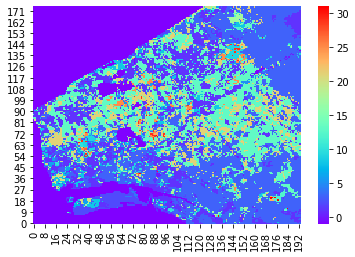

In [36]:
ax = sns.heatmap(cluster_map,cmap='rainbow')
ax.invert_yaxis()

In [37]:
from collections import Counter

most_common_cluster_tuples = Counter(data_stack_clusters).most_common(num_templates)
most_common_clusters = [cluster[0] for cluster in most_common_cluster_tuples]
most_common_layer_templates = [layer_templates[i] for i in most_common_clusters]

In [38]:
most_common_cluster_tuples

[(3, 8693),
 (13, 5726),
 (1, 5045),
 (21, 2162),
 (2, 754),
 (8, 752),
 (17, 320),
 (20, 290),
 (6, 289),
 (25, 267),
 (16, 254),
 (9, 246),
 (12, 184),
 (5, 161),
 (10, 136),
 (0, 83),
 (29, 57),
 (4, 49),
 (23, 35),
 (18, 23),
 (7, 19),
 (19, 19),
 (14, 15),
 (31, 11),
 (27, 8),
 (22, 5),
 (15, 4),
 (30, 4),
 (24, 2),
 (11, 2)]

In [39]:
most_common_layer_templates

['peat - clay',
 'clay - peat - clay',
 'clay',
 'peat - clay - peat - clay',
 'sand',
 'sand - clay',
 'sand - peat - clay',
 'sand - clay - sand',
 'clay - sand',
 'clay - peat - clay - peat',
 'clay - sand - clay',
 'peat - clay - peat',
 'peat - sand - clay',
 'clay - peat',
 'peat - clay - sand',
 'peat',
 'peat - clay - peat - clay - peat',
 'peat - sand',
 'peat - sand - peat - clay',
 'sand - peat - sand',
 'sand - peat',
 'sand - clay - peat',
 'clay - peat - sand',
 'peat - sand - peat - clay - peat',
 'sand - peat - clay - peat',
 'peat - clay - peat - sand',
 'clay - sand - peat',
 'peat - clay - peat - sand - peat',
 'peat - sand - peat - sand',
 'peat - sand - peat']

In [40]:
len(most_common_layer_templates)

30

In [41]:
clusters_per_map = 6
n_maps = int(np.ceil(len(templates)/clusters_per_map))

#Set of n_maps maps, each containing cluster ids of clusters_per_map clusters at a time, in order of cluster size
cluster_maps = []
#cluster_ids contains sets of cluster ids, clusters_per_map at a time, in order of cluster size 
cluster_ids = []
#cluster_templates contains the templates corresponding to cluster_ids
cluster_templates = []

#Initialize count of clusters in cluster_maps. It increases by clusters_per_map every iteration.
count = 0

for n in range(n_maps):
    # cluster_ids_n contains the cluster ids of the clusters, in order of size, 
    # clusters_per_map number of clusters at a time
    cluster_ids_n = most_common_clusters[count : min(count+clusters_per_map,len(templates))]
    # cluster_templates_n contains the layer templates corresponding to cluster_ids_n
    cluster_templates_n = most_common_layer_templates[count : min(count+clusters_per_map,len(templates))]
    # Map of clusters, in which every (x,y) point will be filled in with the cluster id of the cluster it corresponds to
    cluster_map = -np.ones((N_y,N_x))

    for i in range(len(data_stack_clusters)):
        if data_stack_clusters[i] in cluster_ids_n:
            cluster_map[data_stacks_ny[i], data_stacks_nx[i]] = data_stack_clusters[i]
    
    cluster_maps.append(cluster_map)
    cluster_ids.append(cluster_ids_n)
    cluster_templates.append(cluster_templates_n)
    
    count = count + clusters_per_map

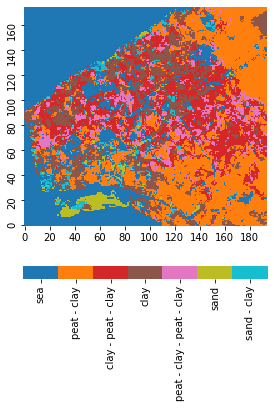

In [42]:
n=0

#The nth cluster "submap", containing clusters_per_map clusters
cluster_map_reference = cluster_maps[n]
#Map to be filled with indices from 1 to clusters_map, corresponding to clusters in cluster_map_reference
cluster_map = -np.ones((N_y,N_x))

#cluster ids of clusters_per_map clusters
cluster_id = cluster_ids[n]
#cluster templates of clusters_per_map clusters
cluster_template = cluster_templates[n]

for index, item in enumerate(cluster_id):
    #cluster_map is filled with integers from 1 to clusters_per_map, corresponding to the clusters in cluster_map_reference
    cluster_map[cluster_map_reference==item] = index

#Append an element "sea" to the cluster_template. This corresponds to all elements of cluster_map 
#which are not assigned to any cluster and have the value 0.
cluster_template.insert(0,'sea')

vmin = -1
vmax = clusters_per_map
xticklabels = 20
yticklabels = 20
cmap = 'tab10'

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cluster_map, vmin=vmin-0.5, vmax=vmax-0.5, xticklabels=xticklabels, yticklabels=yticklabels, 
                 cmap=plt.cm.get_cmap(cmap, len(cluster_id)+1), cbar_kws={"orientation": "horizontal", 'fraction':0.045})
ax.set_aspect('equal')
c_bar = ax.collections[0].colorbar
tick_locations = [vmin+i for i in range(vmax-vmin+1)]
c_bar.set_ticks(list(tick_locations))
c_bar.set_ticklabels(cluster_template)
c_bar.ax.tick_params(rotation=90)
ax.invert_yaxis()

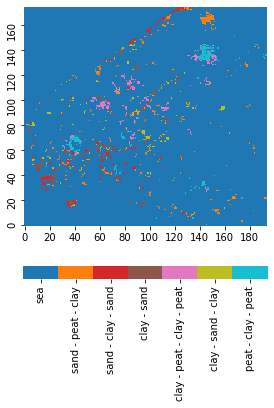

In [43]:
n=1

cluster_map = -np.ones((N_y,N_x))
cluster_map_reference = cluster_maps[n]

cluster_id = cluster_ids[n]
cluster_template = cluster_templates[n]

for index, item in enumerate(cluster_id):
    cluster_map[cluster_map_reference==item] = index

cluster_template.insert(0,'sea')

vmin = -1
vmax = clusters_per_map
xticklabels = 20
yticklabels = 20
cmap = 'tab10'

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cluster_map, vmin=vmin-0.5, vmax=vmax-0.5, xticklabels=xticklabels, yticklabels=yticklabels, 
                 cmap=plt.cm.get_cmap(cmap, len(cluster_id)+1), cbar_kws={"orientation": "horizontal", 'fraction':0.045})
ax.set_aspect('equal')
c_bar = ax.collections[0].colorbar
tick_locations = [vmin+i for i in range(vmax-vmin+1)]
c_bar.set_ticks(list(tick_locations))
c_bar.set_ticklabels(cluster_template)
c_bar.ax.tick_params(rotation=90)
ax.invert_yaxis()

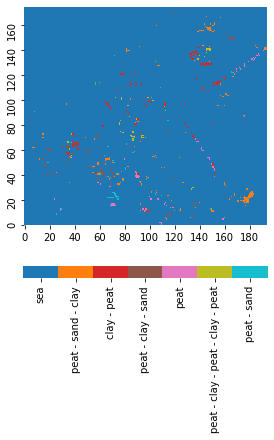

In [44]:
n=2

cluster_map = -np.ones((N_y,N_x))
cluster_map_reference = cluster_maps[n]

cluster_id = cluster_ids[n]
cluster_template = cluster_templates[n]

for index, item in enumerate(cluster_id):
    cluster_map[cluster_map_reference==item] = index

cluster_template.insert(0,'sea')

vmin = -1
vmax = clusters_per_map
xticklabels = 20
yticklabels = 20
cmap = 'tab10'

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cluster_map, vmin=vmin-0.5, vmax=vmax-0.5, xticklabels=xticklabels, yticklabels=yticklabels, 
                 cmap=plt.cm.get_cmap(cmap, len(cluster_id)+1), cbar_kws={"orientation": "horizontal", 'fraction':0.045})
ax.set_aspect('equal')
c_bar = ax.collections[0].colorbar
tick_locations = [vmin+i for i in range(vmax-vmin+1)]
c_bar.set_ticks(list(tick_locations))
c_bar.set_ticklabels(cluster_template)
c_bar.ax.tick_params(rotation=90)
ax.invert_yaxis()

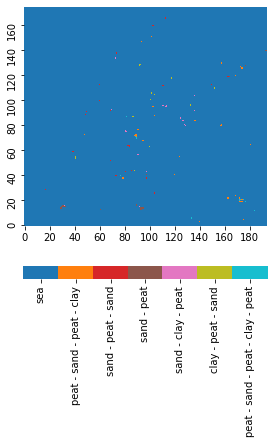

In [45]:
n=3

cluster_map = -np.ones((N_y,N_x))
cluster_map_reference = cluster_maps[n]

cluster_id = cluster_ids[n]
cluster_template = cluster_templates[n]

for index, item in enumerate(cluster_id):
    cluster_map[cluster_map_reference==item] = index

cluster_template.insert(0,'sea')

vmin = -1
vmax = clusters_per_map
xticklabels = 20
yticklabels = 20
cmap = 'tab10'

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cluster_map, vmin=vmin-0.5, vmax=vmax-0.5, xticklabels=xticklabels, yticklabels=yticklabels,
                 cmap=plt.cm.get_cmap(cmap, len(cluster_id)+1), cbar_kws={"orientation": "horizontal", 'fraction':0.045})
ax.set_aspect('equal')
c_bar = ax.collections[0].colorbar
tick_locations = [vmin+i for i in range(vmax-vmin+1)]
c_bar.set_ticks(list(tick_locations))
c_bar.set_ticklabels(cluster_template)
c_bar.ax.tick_params(rotation=90)
ax.invert_yaxis()

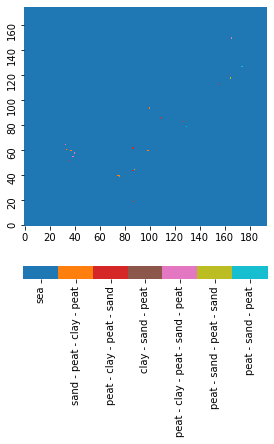

In [46]:
n=4

cluster_map = -np.ones((N_y,N_x))
cluster_map_reference = cluster_maps[n]

cluster_id = cluster_ids[n]
cluster_template = cluster_templates[n]

for index, item in enumerate(cluster_id):
    cluster_map[cluster_map_reference==item] = index

cluster_template.insert(0,'sea')

vmin = -1
vmax = clusters_per_map
xticklabels = 20
yticklabels = 20
cmap = 'tab10'

fig, ax = plt.subplots(figsize=(5,5))
ax = sns.heatmap(cluster_map, vmin=vmin-0.5, vmax=vmax-0.5, xticklabels=xticklabels, yticklabels=yticklabels, 
                 cmap=plt.cm.get_cmap(cmap, len(cluster_id)+1), cbar_kws={"orientation": "horizontal", 'fraction':0.045})
ax.set_aspect('equal')
c_bar = ax.collections[0].colorbar
tick_locations = [vmin+i for i in range(vmax-vmin+1)]
c_bar.set_ticks(list(tick_locations))
c_bar.set_ticklabels(cluster_template)
c_bar.ax.tick_params(rotation=90)
ax.invert_yaxis()

In [47]:
d = {'x':data_stacks_nx, 'y': data_stacks_ny, 'stack': data_stacks}
df = pd.DataFrame(data=d)

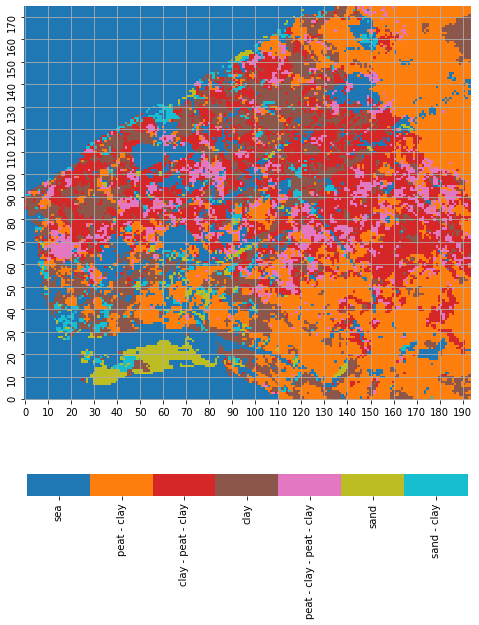

In [48]:
n=0

cluster_map = -np.ones((N_y,N_x))
cluster_map_reference = cluster_maps[n]

cluster_id = cluster_ids[n]
cluster_template = cluster_templates[n]

for index, item in enumerate(cluster_id):
    cluster_map[cluster_map_reference==item] = index

vmin = -1
vmax = clusters_per_map
xticklabels = 10
yticklabels = 10
cmap = 'tab10'

fig, ax = plt.subplots(figsize=(8,9))
ax = sns.heatmap(cluster_map, vmin=vmin-0.5, vmax=vmax-0.5, xticklabels=xticklabels, yticklabels=yticklabels, 
                 cmap=plt.cm.get_cmap(cmap, len(cluster_id)+1), cbar_kws={"orientation": "horizontal", 'fraction':0.045})
c_bar = ax.collections[0].colorbar
tick_locations = [vmin+i for i in range(vmax-vmin+1)]
c_bar.set_ticks(list(tick_locations))
c_bar.set_ticklabels(cluster_template)
c_bar.ax.tick_params(rotation=90)
ax.grid()
ax.invert_yaxis()